just a toy notebook but needs to be cleaned up and more descriptive might do later
next goal is 3d modeling really need to have self-adapting hyper-param tuning will implement later once this proof-of-concept is benchmarked more

In [1]:
!pip install warp-lang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 MB 13.1 MB/s eta 0:00:0000:0100:01


In [2]:
import warp as wp
import numpy as np
import torch

wp.init()

Warp 1.9.1 initialized:
   CUDA Toolkit 12.8, Driver 12.6
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "Tesla P100-PCIE-16GB" (16 GiB, sm_60, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.9.1


In [3]:
import warp as wp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

wp.init()

@wp.struct
class Ray:
    origin: wp.vec3
    dir: wp.vec3


@wp.func
def influence_func(sample_pos: wp.vec3, drop_pos: wp.vec3, sigma: wp.float32):
    """Calculates the influence of a drop at a sample point."""
    dist_sq = wp.length_sq(sample_pos - drop_pos)
    sigma_sq = sigma * sigma
    return wp.exp(-dist_sq / (2.0 * sigma_sq + 1e-9))


@wp.kernel
def volumetric_trace(
    # Scene Data
    grid: wp.uint64,
    drop_positions: wp.array(dtype=wp.vec3),
    drop_learnable_params: wp.array(dtype=wp.float32, ndim=2),

    # Input/Output
    initial_rays: wp.array(dtype=Ray),
    outputs: wp.array(dtype=wp.float32),

    # Kernel Parameters
    num_steps: wp.int32,
    step_size: wp.float32,
    query_radius: wp.float32
):
    """Traces rays through the volume and accumulates radiance."""
    tid = wp.tid()
    ray = initial_rays[tid]
    accumulated_radiance = wp.float32(0.0)

    for i in range(num_steps):
        t = wp.float32(i) * step_size
        sample_pos = ray.origin + ray.dir * t

        query = wp.hash_grid_query(grid, sample_pos, query_radius)
        candidate_index = wp.int32(0)
        
        local_radiance = wp.float32(0.0)

        while wp.hash_grid_query_next(query, candidate_index):
            drop_weight = wp.clamp(drop_learnable_params[candidate_index, 0], -1.0, 1.0)
            drop_energy = wp.clamp(drop_learnable_params[candidate_index, 1], 0.0, 5.0)
            drop_sigma  = wp.clamp(drop_learnable_params[candidate_index, 2], 0.01, 2.0)

            influence = influence_func(sample_pos, drop_positions[candidate_index], drop_sigma)
            contribution = influence * drop_weight * drop_energy
            local_radiance += contribution
        
        accumulated_radiance += local_radiance * step_size
    
    outputs[tid] = accumulated_radiance


class VolumetricSplattingLayer(nn.Module):
    """
    A plug-and-play neural network layer for volumetric rendering.
    Manages its own state of "drops" and handles rendering, densification, and pruning.
    """
    def __init__(self, initial_positions, initial_learnable_params, device,
                 densify_start_step=100, densify_interval=100,
                 prune_threshold_weight=0.005, densify_grad_threshold=0.001,
                 split_threshold_sigma=0.5, ema_beta=0.9):
        super().__init__()
        self.device = 'cuda'
        self.positions = nn.Parameter(torch.tensor(initial_positions, device=self.device))
        self.learnable_params = nn.Parameter(torch.tensor(initial_learnable_params, device=self.device))

        self.densify_start_step = densify_start_step
        self.densify_interval = densify_interval
        self.prune_threshold_weight = prune_threshold_weight
        self.densify_grad_threshold = densify_grad_threshold
        self.split_threshold_sigma = split_threshold_sigma
        
        self.ema_beta = ema_beta
        self.position_grad_ema = torch.zeros_like(self.positions)

    def forward(self, initial_rays_wp: wp.array):
        """
        Performs the forward pass: renders the volume for the given rays.
        """
        num_initial_rays = initial_rays_wp.shape[0]
        
        # Rebuild HashGrid at every step since positions are learnable
        # Store these warp arrays as attributes to be accessed in the backward pass
        self.current_positions_wp = wp.from_torch(self.positions, dtype=wp.vec3)
        grid = wp.HashGrid(dim_x=128, dim_y=128, dim_z=128, device=self.device)
        grid.build(points=self.current_positions_wp, radius=2.0)
        
        self.learnable_params_wp = wp.from_torch(self.learnable_params)
        outputs_tensor = torch.zeros(num_initial_rays, dtype=torch.float32, device=self.device)
        self.outputs_wp = wp.from_torch(outputs_tensor)

        
        self.tape = wp.Tape()
        with self.tape:
            wp.launch(
                kernel=volumetric_trace,
                dim=num_initial_rays,
                inputs=[
                    grid.id,
                    self.current_positions_wp,
                    self.learnable_params_wp,
                    initial_rays_wp,
                    self.outputs_wp,
                    64, 0.2, 1.5 # num_steps, step_size, query_radius
                ],
                device=self.device
            )
        
        return outputs_tensor

    @torch.no_grad()
    def update_state(self, step: int, optimizer: torch.optim.Optimizer):
        """
        Updates the layer's state by pruning and densifying drops.
        This should be called from the main training loop.
        Returns True if the optimizer needs to be reset.
        """
        if step <= self.densify_start_step or step % self.densify_interval != 0:
            return False

        if self.positions.grad is None:
            return False

        # Update gradient EMA for stable densification ---
        self.position_grad_ema = self.ema_beta * self.position_grad_ema + \
                                 (1.0 - self.ema_beta) * self.positions.grad
        
        pos_grads_magnitude = torch.norm(self.position_grad_ema, dim=1)
        
        print(f"--- Step {step:03d}: Densification ---")
        print(f"Max position grad magnitude (EMA): {pos_grads_magnitude.max().item():.6f}")

        # prune
        prune_mask = torch.abs(self.learnable_params[:, 0]) > self.prune_threshold_weight
        n_pruned = self.positions.shape[0] - prune_mask.sum().item()
        
        if n_pruned > 0:
            self.positions.data = self.positions.data[prune_mask]
            self.learnable_params.data = self.learnable_params.data[prune_mask]
            pos_grads_magnitude = pos_grads_magnitude[prune_mask]
            self.position_grad_ema = self.position_grad_ema[prune_mask]

        # splitting
        split_mask = (self.learnable_params[:, 2] > self.split_threshold_sigma) & (pos_grads_magnitude > self.densify_grad_threshold)
        n_split = 0
        if split_mask.any():
            n_split = split_mask.sum().item()
            split_positions = self.positions.data[split_mask]
            split_learnables = self.learnable_params.data[split_mask]

            new_positions = split_positions.repeat(2, 1)
            new_learnables = split_learnables.repeat(2, 1)
            new_learnables[:, 2] *= 0.7
            new_learnables[:, 0] *= 0.7 
            
            stdev = torch.sqrt(new_learnables[:n_split, 2])
            mean = torch.zeros_like(stdev)
            offset_dir = self.positions.grad[prune_mask if n_pruned > 0 else torch.ones_like(prune_mask, dtype=torch.bool)][split_mask]
            offset = torch.normal(mean, stdev).unsqueeze(1) * (offset_dir / (torch.norm(offset_dir, dim=1, keepdim=True) + 1e-9))

            new_positions[:n_split] += offset
            new_positions[n_split:] -= offset
            
            keep_mask = ~split_mask
            self.positions.data = torch.cat((self.positions.data[keep_mask], new_positions), dim=0)
            self.learnable_params.data = torch.cat((self.learnable_params.data[keep_mask], new_learnables), dim=0)

            split_grads_magnitude = pos_grads_magnitude[split_mask].repeat(2)
            pos_grads_magnitude = torch.cat((pos_grads_magnitude[keep_mask], split_grads_magnitude), dim=0)

            split_grad_ema = self.position_grad_ema[split_mask].repeat(2, 1)
            self.position_grad_ema = torch.cat((self.position_grad_ema[keep_mask], split_grad_ema), dim=0)

        # cloning
        clone_mask = (self.learnable_params[:, 2] <= self.split_threshold_sigma) & (pos_grads_magnitude > self.densify_grad_threshold)
        n_cloned = 0
        if clone_mask.any():
            n_cloned = clone_mask.sum().item()
            clone_positions = self.positions.data[clone_mask]
            clone_learnables = self.learnable_params.data[clone_mask]

            self.learnable_params.data[clone_mask, 0] /= 2.0
            
            self.positions.data = torch.cat((self.positions.data, clone_positions), dim=0)
            self.learnable_params.data = torch.cat((self.learnable_params.data, clone_learnables), dim=0)
            self.position_grad_ema = torch.cat((self.position_grad_ema, self.position_grad_ema[clone_mask]), dim=0)


        if n_pruned > 0 or n_split > 0 or n_cloned > 0:
            print(f"Pruned: {n_pruned}, Split: {n_split}, Cloned: {n_cloned}.")
            return True # Optimizer needs reset
            
        return False



# Simulation setup
num_drops_initial = 20
num_initial_rays = 8192
training_steps = 800
device = wp.get_preferred_device()
torch_device = 'cuda' if wp.get_device(device).is_cuda else 'cpu'
lambda_l1 = 1e-4

# init drop data
rng = np.random.default_rng(42)
positions_np = (rng.random(size=(num_drops_initial, 3), dtype=np.float32) - 0.5) * 8.0
positions_np[:, 2] += 5.0
initial_weights = (rng.random(size=(num_drops_initial, 1), dtype=np.float32) - 0.5) * 0.1
initial_energies = np.ones((num_drops_initial, 1), dtype=np.float32)
initial_sigmas = np.full((num_drops_initial, 1), 0.5, dtype=np.float32)
learnable_data_np = np.hstack([initial_weights, initial_energies, initial_sigmas])

#fake data and rays
y_true_np = np.zeros(num_initial_rays, dtype=np.float32)
num_rays_side = int(np.sqrt(num_initial_rays))
for j in range(num_rays_side):
    for i in range(num_rays_side):
        idx = j * num_rays_side + i
        if idx >= num_initial_rays: continue
        u, v = (i / (num_rays_side - 1) - 0.5) * 2.0, (j / (num_rays_side - 1) - 0.5) * 2.0
        y_true_np[idx] = 5.0 * np.exp(-(u*u + v*v) / (2.0 * 0.5**2.0))
y_true_tensor = torch.tensor(y_true_np, device=torch_device)

initial_rays_np = np.empty(num_initial_rays, dtype=Ray.numpy_dtype())
for j in range(num_rays_side):
    for i in range(num_rays_side):
        idx = j * num_rays_side + i
        if idx >= num_initial_rays: continue
        ox, oy = (i / (num_rays_side - 1) - 0.5) * 5.0, (j / (num_rays_side - 1) - 0.5) * 5.0
        initial_rays_np[idx]['origin'], initial_rays_np[idx]['dir'] = (ox, oy, -1.0), (0.0, 0.0, 1.0)
initial_rays_wp = wp.array(initial_rays_np, dtype=Ray, device=device)

model = VolumetricSplattingLayer(positions_np, learnable_data_np, device).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(f"\n training for like {training_steps} steps ---")

for step in range(training_steps):
    optimizer.zero_grad()
    #forward
    outputs_tensor = model(initial_rays_wp)
    
    # loss calc
    rendering_loss = F.mse_loss(outputs_tensor, y_true_tensor)
    l1_loss = lambda_l1 * torch.abs(model.learnable_params[:, 0]).sum()
    total_loss = rendering_loss + l1_loss
    
    # back pass
    # get rend grads from warp
    seed_grad_tensor = (2.0 / outputs_tensor.numel()) * (outputs_tensor - y_true_tensor)
    seed_grad_wp = wp.from_torch(seed_grad_tensor.contiguous())
    # Use the output warp array stored as a model attribute as the key
    model.tape.backward(grads={model.outputs_wp: seed_grad_wp})
    
    # Retrieve gradients using the input warp arrays (also stored as attributes)
    model.learnable_params.grad = wp.to_torch(model.tape.gradients[model.learnable_params_wp])
    model.positions.grad = wp.to_torch(model.tape.gradients[model.current_positions_wp])
    
    # Manually add L1 grads to avoid autograd issues with in-place updates
    with torch.no_grad():
        # Gradient of L1 loss is lambda * sign(parameter)
        l1_grad_weights = lambda_l1 * torch.sign(model.learnable_params.data[:, 0])
        
        # Create a zero tensor with the same shape as the full gradient
        l1_grad_full = torch.zeros_like(model.learnable_params.grad)
        
        # Place the weight gradients in the first column
        l1_grad_full[:, 0] = l1_grad_weights
        
        # Accumulate the gradients
        model.learnable_params.grad += l1_grad_full

    # optimizer step
    optimizer.step()

    # prune and densiffy 
    if model.update_state(step, optimizer):
        # If drops were added/removed, we must reset the optimizer's state
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    if step % 10 == 0 or step == training_steps - 1:
        print(f"Step {step:03d}, Total Loss: {total_loss.item():.6f} (Render: {rendering_loss.item():.6f}, L1: {l1_loss.item():.6f}), Num Drops: {model.positions.shape[0]}")

print("\n--- Training complete ---")


 training for like 800 steps ---
Module __main__ fdcb5e4 load on device 'cuda:0' took 595.25 ms  (compiled)
Step 000, Total Loss: 4.695064 (Render: 4.695020, L1: 0.000044), Num Drops: 20
Step 010, Total Loss: 4.388967 (Render: 4.388768, L1: 0.000199), Num Drops: 20
Step 020, Total Loss: 3.584888 (Render: 3.584486, L1: 0.000402), Num Drops: 20
Step 030, Total Loss: 2.248029 (Render: 2.247488, L1: 0.000541), Num Drops: 20
Step 040, Total Loss: 1.116815 (Render: 1.116295, L1: 0.000520), Num Drops: 20
Step 050, Total Loss: 0.378412 (Render: 0.377994, L1: 0.000418), Num Drops: 20
Step 060, Total Loss: 0.098726 (Render: 0.098370, L1: 0.000356), Num Drops: 20
Step 070, Total Loss: 0.032836 (Render: 0.032507, L1: 0.000329), Num Drops: 20
Step 080, Total Loss: 0.017201 (Render: 0.016891, L1: 0.000309), Num Drops: 20
Step 090, Total Loss: 0.005682 (Render: 0.005378, L1: 0.000305), Num Drops: 20
Step 100, Total Loss: 0.004783 (Render: 0.004486, L1: 0.000297), Num Drops: 20
Step 110, Total Loss: 

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warp as wp
wp.init()

@wp.struct
class Ray:
    origin: wp.vec3
    dir: wp.vec3

@wp.func
def influence_func(sample_pos: wp.vec3, drop_pos: wp.vec3, sigma: wp.float32):
    dist_sq = wp.length_sq(sample_pos - drop_pos)
    sigma_sq = sigma * sigma
    return wp.exp(-dist_sq / (2.0 * sigma_sq + 1e-9))

@wp.kernel
def volumetric_trace(grid: wp.uint64, drop_positions: wp.array(dtype=wp.vec3), drop_learnable_params: wp.array(dtype=wp.float32, ndim=2), initial_rays: wp.array(dtype=Ray), outputs: wp.array(dtype=wp.float32), num_steps: wp.int32, step_size: wp.float32, query_radius: wp.float32):
    tid = wp.tid()
    ray = initial_rays[tid]
    accumulated_radiance = wp.float32(0.0)
    for i in range(num_steps):
        t = wp.float32(i) * step_size
        sample_pos = ray.origin + ray.dir * t
        query = wp.hash_grid_query(grid, sample_pos, query_radius)
        candidate_index = wp.int32(0)
        local_radiance = wp.float32(0.0)
        while wp.hash_grid_query_next(query, candidate_index):
            drop_weight = wp.clamp(drop_learnable_params[candidate_index, 0], -1.0, 1.0)
            drop_energy = wp.clamp(drop_learnable_params[candidate_index, 1], 0.0, 5.0)
            drop_sigma  = wp.clamp(drop_learnable_params[candidate_index, 2], 0.01, 2.0)
            influence = influence_func(sample_pos, drop_positions[candidate_index], drop_sigma)
            contribution = influence * drop_weight * drop_energy
            local_radiance += contribution
        accumulated_radiance += local_radiance * step_size
    outputs[tid] = accumulated_radiance

class VolumetricSplattingLayer(nn.Module):
    def __init__(self, initial_positions, initial_learnable_params, device, densify_start_step=100, densify_interval=100, prune_threshold_weight=0.01, densify_grad_threshold=0.001, split_threshold_sigma=0.5, ema_beta=0.9):
        super().__init__()
        self.device = device
        self.positions = nn.Parameter(torch.tensor(initial_positions, device=self.device))
        self.learnable_params = nn.Parameter(torch.tensor(initial_learnable_params, device=self.device))
        self.densify_start_step = densify_start_step
        self.densify_interval = densify_interval
        self.prune_threshold_weight = prune_threshold_weight
        self.densify_grad_threshold = densify_grad_threshold
        self.split_threshold_sigma = split_threshold_sigma
        self.ema_beta = ema_beta
        self.position_grad_ema = torch.zeros_like(self.positions)

    def forward(self, initial_rays_wp: wp.array, num_steps=64, step_size=0.2, query_radius=1.5):
        num_initial_rays = initial_rays_wp.shape[0]
        self.current_positions_wp = wp.from_torch(self.positions, dtype=wp.vec3)
        grid = wp.HashGrid(dim_x=128, dim_y=128, dim_z=128, device=self.device)
        grid.build(points=self.current_positions_wp, radius=2.0)
        self.learnable_params_wp = wp.from_torch(self.learnable_params)
        outputs_tensor = torch.zeros(num_initial_rays, dtype=torch.float32, device=self.device)
        self.outputs_wp = wp.from_torch(outputs_tensor)
        self.tape = wp.Tape()
        with self.tape:
            wp.launch(kernel=volumetric_trace, dim=num_initial_rays, inputs=[grid.id, self.current_positions_wp, self.learnable_params_wp, initial_rays_wp, self.outputs_wp, num_steps, step_size, query_radius], device=self.device)
        return outputs_tensor

    @torch.no_grad()
    def update_state(self, step: int, optimizer: torch.optim.Optimizer):
        if step <= self.densify_start_step or step % self.densify_interval != 0:
            return False
        if self.positions.grad is None:
            return False
        
        
        # EMA update
        self.position_grad_ema = self.ema_beta * self.position_grad_ema + (1.0 - self.ema_beta) * self.positions.grad
        pos_grads_magnitude = torch.norm(self.position_grad_ema, dim=1)
        
        
        # prune
        prune_mask = torch.abs(self.learnable_params[:, 0]) > self.prune_threshold_weight
        n_pruned = self.positions.shape[0] - prune_mask.sum().item()
        if n_pruned > 0:
            self.positions.data = self.positions.data[prune_mask]
            self.learnable_params.data = self.learnable_params.data[prune_mask]
            self.position_grad_ema = self.position_grad_ema[prune_mask]
            pos_grads_magnitude = torch.norm(self.position_grad_ema, dim=1) # recompute after pruning
            
            
        # splitting
        split_mask = (self.learnable_params[:, 2] > self.split_threshold_sigma) & (pos_grads_magnitude > self.densify_grad_threshold)
        n_split = 0
        if split_mask.any():
            n_split = split_mask.sum().item()
            split_positions = self.positions.data[split_mask]
            split_learnables = self.learnable_params.data[split_mask]
            
            
            new_positions = split_positions.repeat(2, 1)
            new_learnables = split_learnables.repeat(2, 1)
            new_learnables[:, 2] *= 0.7
            new_learnables[:, 0] *= 0.7
            
            
            stdev = torch.sqrt(new_learnables[:n_split, 2])
            mean = torch.zeros_like(stdev)
            offset_dir = self.position_grad_ema[split_mask]
            offset = torch.normal(mean, stdev).unsqueeze(1) * (offset_dir / (torch.norm(offset_dir, dim=1, keepdim=True) + 1e-9))
            
            
            new_positions[:n_split] += offset
            new_positions[n_split:] -= offset
            
            
            keep_mask = ~split_mask
            self.positions.data = torch.cat((self.positions.data[keep_mask], new_positions), dim=0)
            self.learnable_params.data = torch.cat((self.learnable_params.data[keep_mask], new_learnables), dim=0)
            self.position_grad_ema = torch.cat((self.position_grad_ema[keep_mask], self.position_grad_ema[split_mask].repeat(2, 1)), dim=0)
            
            
            # recompute pos_grads_magnitude after split
            pos_grads_magnitude = torch.norm(self.position_grad_ema, dim=1)
            
        
        # cloning
        clone_mask = (self.learnable_params[:, 2] <= self.split_threshold_sigma) & (pos_grads_magnitude > self.densify_grad_threshold)
        n_cloned = 0
        if clone_mask.any():
            n_cloned = clone_mask.sum().item()
            clone_positions = self.positions.data[clone_mask]
            clone_learnables = self.learnable_params.data[clone_mask]
            
            
            self.learnable_params.data[clone_mask, 0] /= 2.0
            
            
            self.positions.data = torch.cat((self.positions.data, clone_positions), dim=0)
            self.learnable_params.data = torch.cat((self.learnable_params.data, clone_learnables), dim=0)
            self.position_grad_ema = torch.cat((self.position_grad_ema, self.position_grad_ema[clone_mask]), dim=0)
            
        
        if n_pruned > 0 or n_split > 0 or n_cloned > 0:
            print(f"Pruned: {n_pruned}, Split: {n_split}, Cloned: {n_cloned}.")
            return True
        
        
        return False

In [5]:

def build_rays_for_mnist(side=28, pixel_scale=5.0, z_offset=-1.0):
    num_rays = side * side
    initial_rays_np = np.empty(num_rays, dtype=Ray.numpy_dtype())
    for j in range(side):
        for i in range(side):
            idx = j * side + i
            ox = (i / (side - 1) - 0.5) * pixel_scale
            oy = (j / (side - 1) - 0.5) * pixel_scale
            initial_rays_np[idx]['origin'] = (ox, oy, z_offset)
            initial_rays_np[idx]['dir'] = (0.0, 0.0, 1.0)
    return initial_rays_np


def visualize_render(outputs, step, out_dir, side=28, display_image=True):
    img = outputs.reshape(side, side).cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Step {step}")
    plt.tight_layout()
    
    # Save the image
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, f"render_{step:05d}.png"))
    
    # Display the image if running in an interactive environment (Kaggle/Jupyter Cell)
    if display_image:
        plt.show()
    else:
        plt.close() # Close if not showing to save memory


def main():
    device = wp.get_preferred_device()
    torch_device = 'cuda' if wp.get_device(device).is_cuda else 'cpu'
    print("Warp device:", device, "-> Torch device:", torch_device)

    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)

    # model init
    num_drops_initial = 200
    rng = np.random.default_rng(123)
    positions_np = (rng.random(size=(num_drops_initial, 3), dtype=np.float32) - 0.5) * 8.0
    positions_np[:, 2] += 5.0
    initial_weights = (rng.random(size=(num_drops_initial, 1), dtype=np.float32) - 0.5) * 0.1
    initial_energies = np.ones((num_drops_initial, 1), dtype=np.float32)
    initial_sigmas = np.full((num_drops_initial, 1), 0.5, dtype=np.float32)
    learnable_data_np = np.hstack([initial_weights, initial_energies, initial_sigmas])

    model = VolumetricSplattingLayer(positions_np, learnable_data_np, 'cuda').to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    # rays (fixed grid matching MNIST pixels)
    num_rays_side = 28
    initial_rays_np = build_rays_for_mnist(side=num_rays_side, pixel_scale=5.0, z_offset=-1.0)
    initial_rays_wp = wp.array(initial_rays_np, dtype=Ray, device=device)

    # training schedule
    images_to_train = 10          # how many MNIST images to try reconstructing (increase as needed)
    steps_per_image = 200         # gradient steps per image
    lambda_l1 = 1e-4
    out_dir = './mnist_renders'

    global_step = 0
    print(f"Training on {images_to_train} MNIST images, {steps_per_image} steps each")

    for img_idx, (img, label) in enumerate(loader):
        if img_idx >= images_to_train:
            break

        print(f"\n--- Image {img_idx+1}/{images_to_train} (label={label.item()}) ---")
        y_true = img[0].flatten().to(torch_device)
        y_true = y_true / (y_true.max() + 1e-9)

        for step in range(steps_per_image):
            optimizer.zero_grad()

            outputs_tensor = model(initial_rays_wp)

            rendering_loss = F.mse_loss(outputs_tensor, y_true)
            l1_loss = lambda_l1 * torch.abs(model.learnable_params[:, 0]).sum()
            total_loss = rendering_loss + l1_loss

            # backward through warp
            seed_grad_tensor = (2.0 / outputs_tensor.numel()) * (outputs_tensor - y_true)
            seed_grad_wp = wp.from_torch(seed_grad_tensor.contiguous())
            model.tape.backward(grads={model.outputs_wp: seed_grad_wp})

            # fetch grads back to torch
            model.learnable_params.grad = wp.to_torch(model.tape.gradients[model.learnable_params_wp])
            model.positions.grad = wp.to_torch(model.tape.gradients[model.current_positions_wp])

            # add L1 grad
            with torch.no_grad():
                l1_grad_weights = lambda_l1 * torch.sign(model.learnable_params.data[:, 0])
                l1_grad_full = torch.zeros_like(model.learnable_params.grad)
                l1_grad_full[:, 0] = l1_grad_weights
                model.learnable_params.grad += l1_grad_full

            # optional grad clip
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # densify/prune step (if it changes the params, reset optimizer)
            if model.update_state(global_step, optimizer):
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # RENDER AND VISUALIZE
            if step % 10 == 0 or step == steps_per_image - 1:
                print(f"Img {img_idx} Step {step:04d} | Total Loss: {total_loss.item():.6f} | Render: {rendering_loss.item():.6f} | Drops: {model.positions.shape[0]}")
                # The 'True' flag here ensures the image is displayed in the notebook cell.
                visualize_render(outputs_tensor, global_step, out_dir, side=num_rays_side, display_image=False)

            global_step += 1

    print("\nTraining loop finished. Renders saved in:", out_dir)


if __name__ == '__main__':
    main()


Warp device: cuda:0 -> Torch device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.54MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.32MB/s]


Training on 10 MNIST images, 200 steps each

--- Image 1/10 (label=8) ---
Module __main__ 72db5d3 load on device 'cuda:0' took 830.96 ms  (compiled)
Img 0 Step 0000 | Total Loss: 0.097208 | Render: 0.096691 | Drops: 200
Img 0 Step 0010 | Total Loss: 0.059183 | Render: 0.058747 | Drops: 200
Img 0 Step 0020 | Total Loss: 0.048232 | Render: 0.047697 | Drops: 200
Img 0 Step 0030 | Total Loss: 0.043248 | Render: 0.042636 | Drops: 200
Img 0 Step 0040 | Total Loss: 0.040073 | Render: 0.039355 | Drops: 200
Img 0 Step 0050 | Total Loss: 0.037795 | Render: 0.037020 | Drops: 200
Img 0 Step 0060 | Total Loss: 0.036059 | Render: 0.035224 | Drops: 200
Img 0 Step 0070 | Total Loss: 0.034655 | Render: 0.033780 | Drops: 200
Img 0 Step 0080 | Total Loss: 0.033481 | Render: 0.032587 | Drops: 200
Img 0 Step 0090 | Total Loss: 0.032440 | Render: 0.031537 | Drops: 200
Img 0 Step 0100 | Total Loss: 0.031529 | Render: 0.030616 | Drops: 200
Img 0 Step 0110 | Total Loss: 0.030705 | Render: 0.029778 | Drops: 200

DISPLAYING ALL 210 RENDER FRAMES
File: render_00000.png


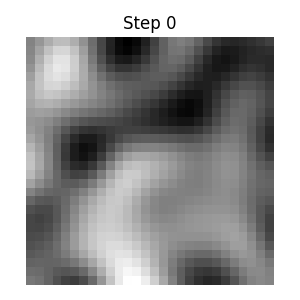

File: render_00010.png


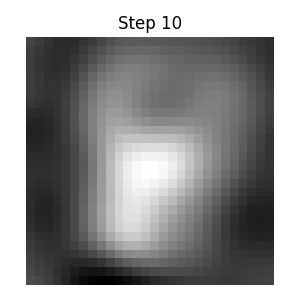

File: render_00020.png


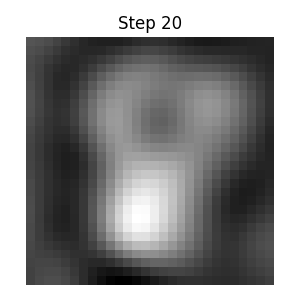

File: render_00030.png


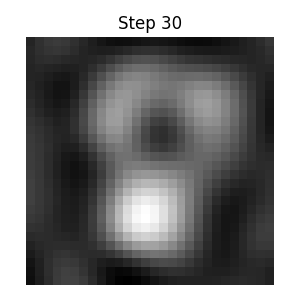

File: render_00040.png


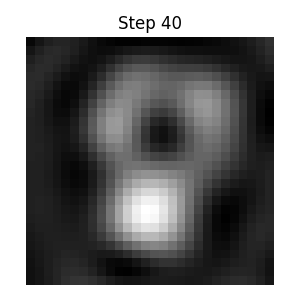

File: render_00050.png


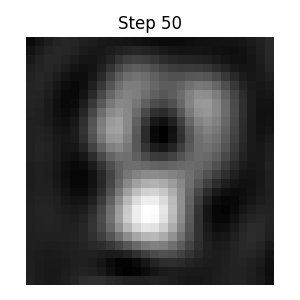

File: render_00060.png


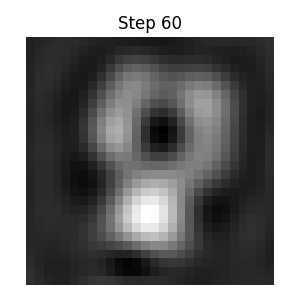

File: render_00070.png


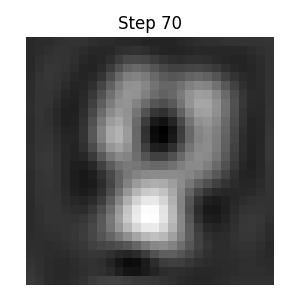

File: render_00080.png


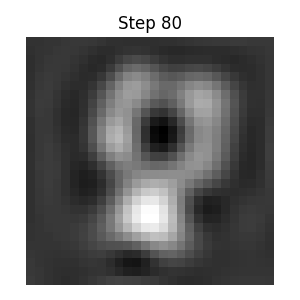

File: render_00090.png


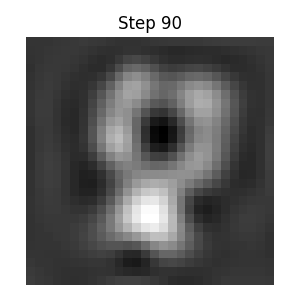

File: render_00100.png


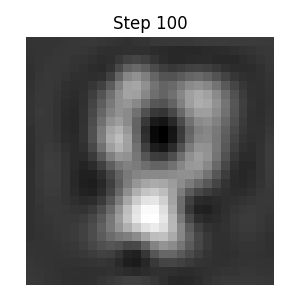

File: render_00110.png


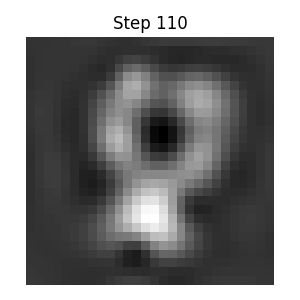

File: render_00120.png


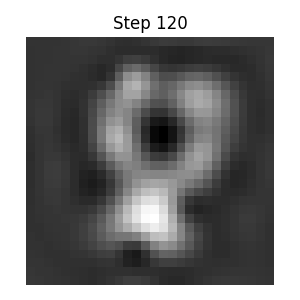

File: render_00130.png


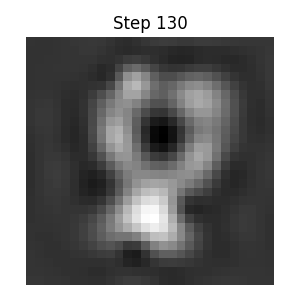

File: render_00140.png


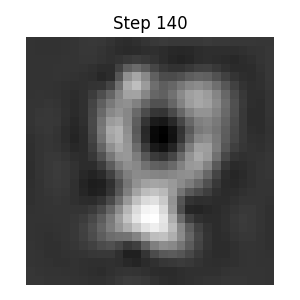

File: render_00150.png


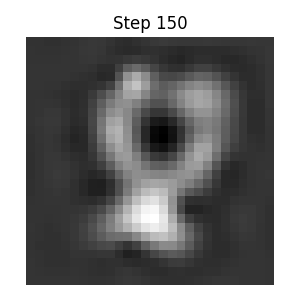

File: render_00160.png


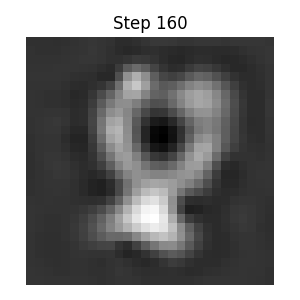

File: render_00170.png


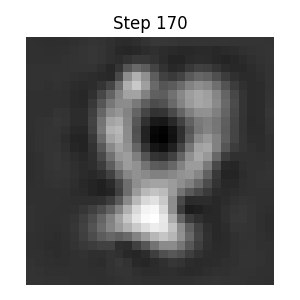

File: render_00180.png


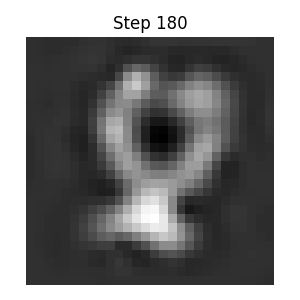

File: render_00190.png


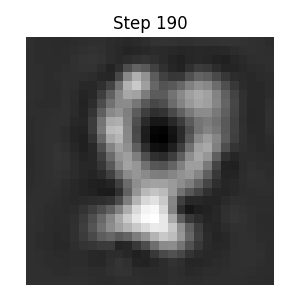

File: render_00199.png


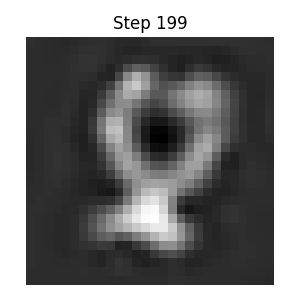

File: render_00200.png


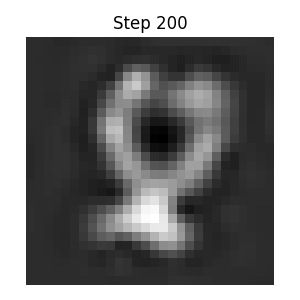

File: render_00210.png


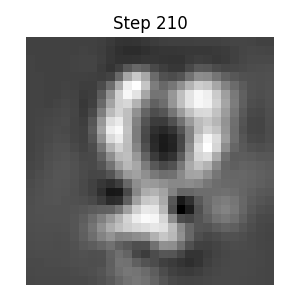

File: render_00220.png


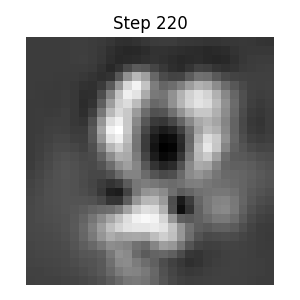

File: render_00230.png


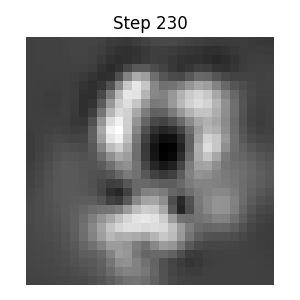

File: render_00240.png


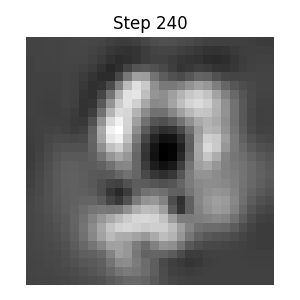

File: render_00250.png


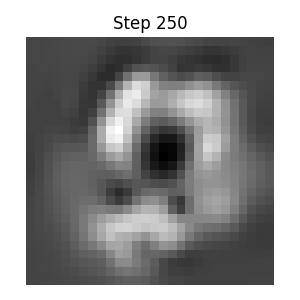

File: render_00260.png


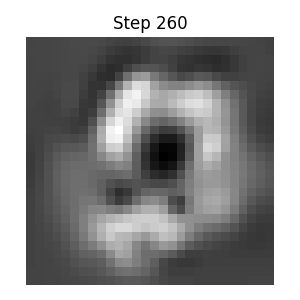

File: render_00270.png


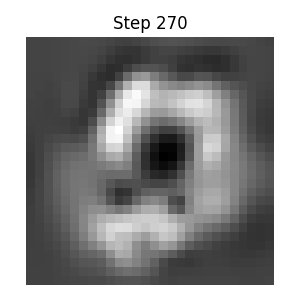

File: render_00280.png


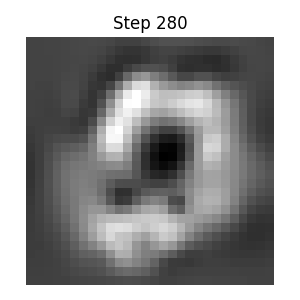

File: render_00290.png


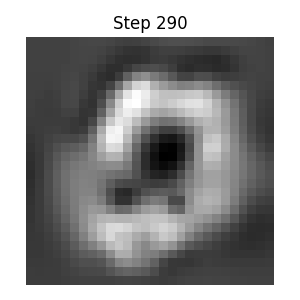

File: render_00300.png


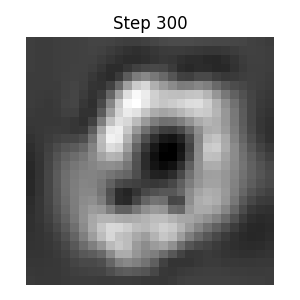

File: render_00310.png


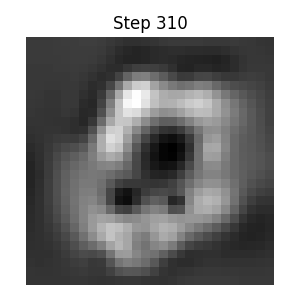

File: render_00320.png


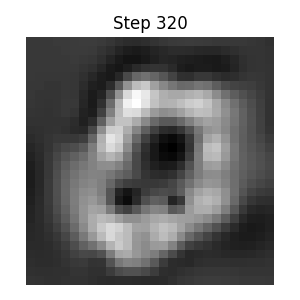

File: render_00330.png


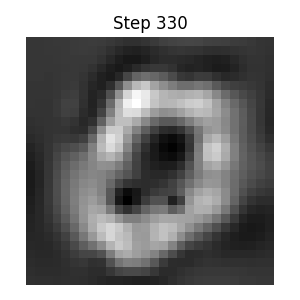

File: render_00340.png


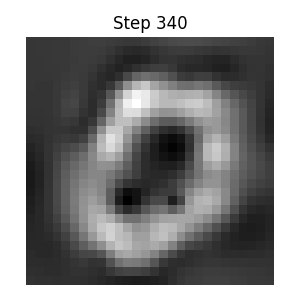

File: render_00350.png


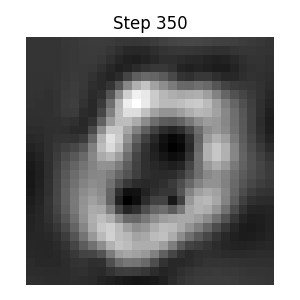

File: render_00360.png


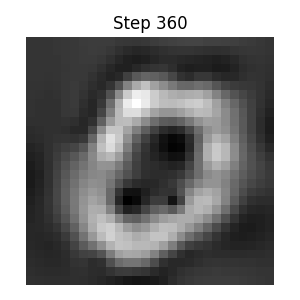

File: render_00370.png


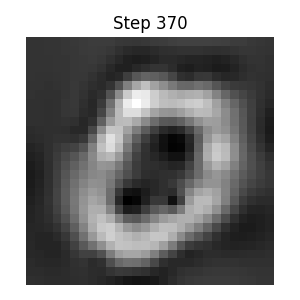

File: render_00380.png


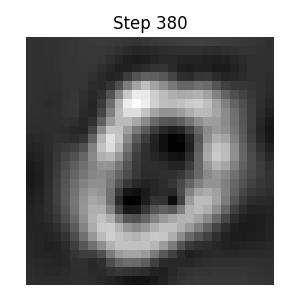

File: render_00390.png


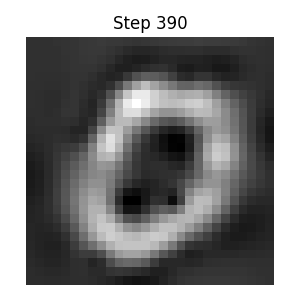

File: render_00399.png


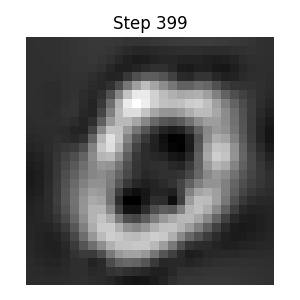

File: render_00400.png


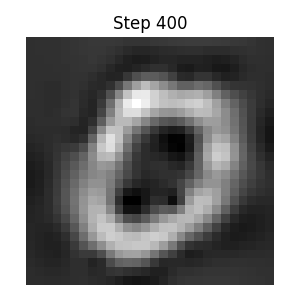

File: render_00410.png


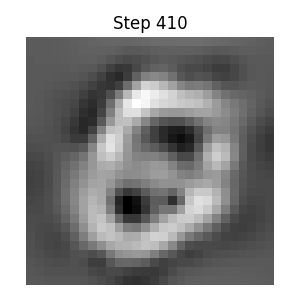

File: render_00420.png


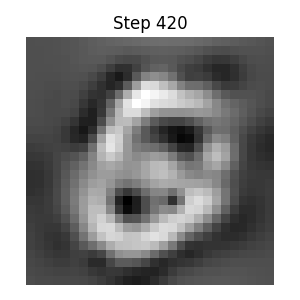

File: render_00430.png


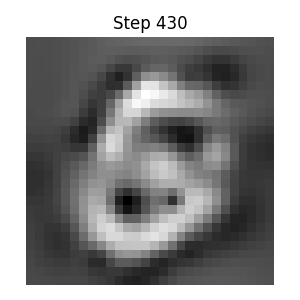

File: render_00440.png


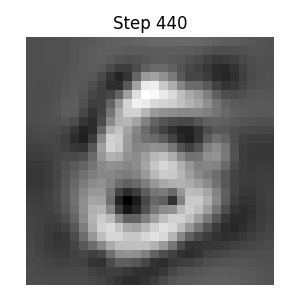

File: render_00450.png


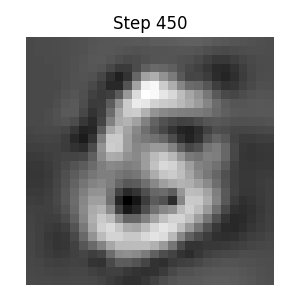

File: render_00460.png


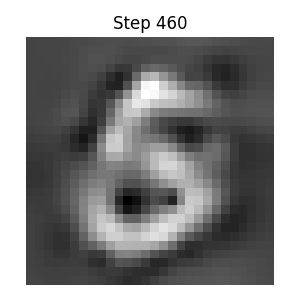

File: render_00470.png


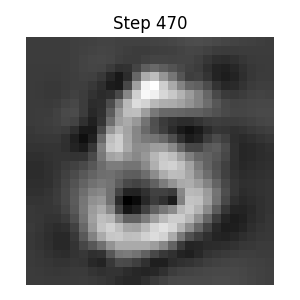

File: render_00480.png


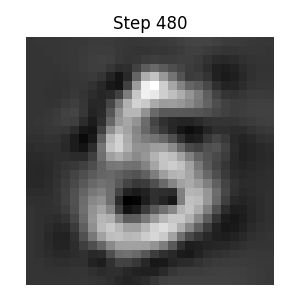

File: render_00490.png


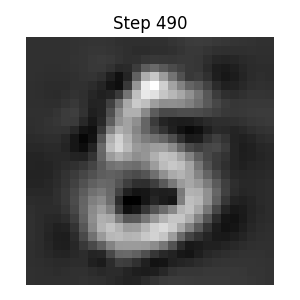

File: render_00500.png


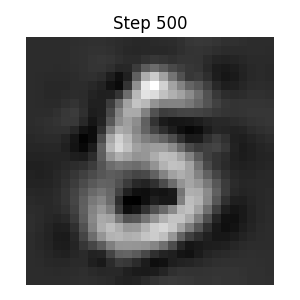

File: render_00510.png


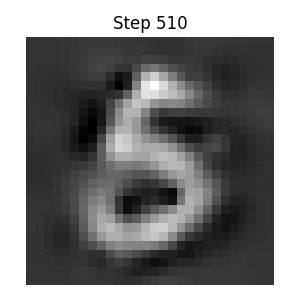

File: render_00520.png


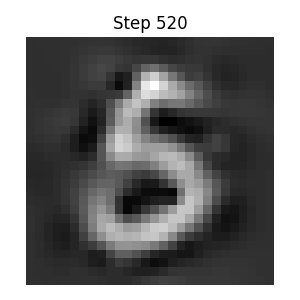

File: render_00530.png


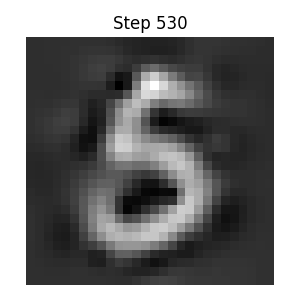

File: render_00540.png


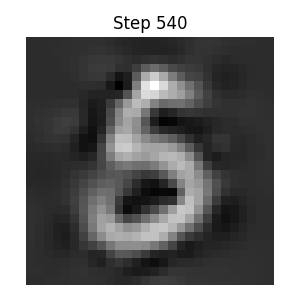

File: render_00550.png


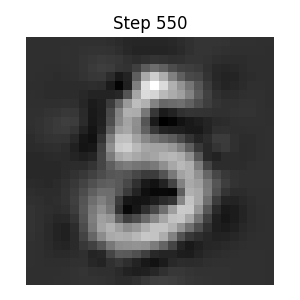

File: render_00560.png


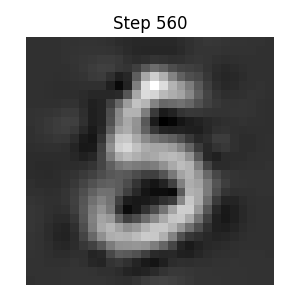

File: render_00570.png


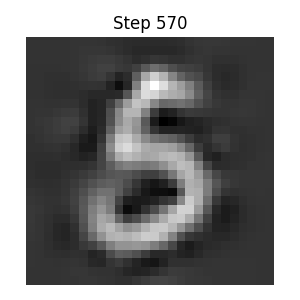

File: render_00580.png


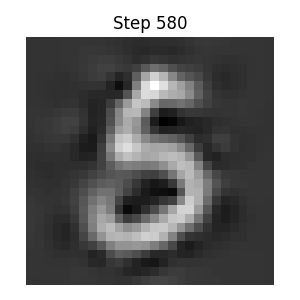

File: render_00590.png


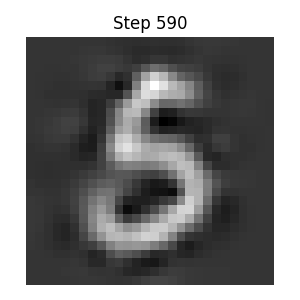

File: render_00599.png


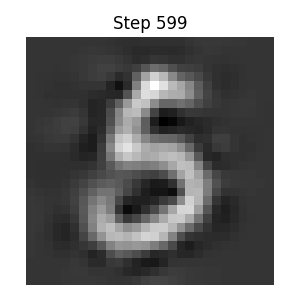

File: render_00600.png


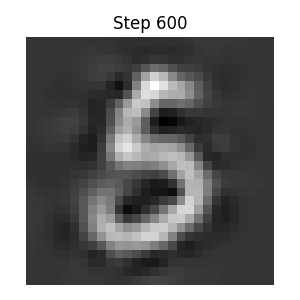

File: render_00610.png


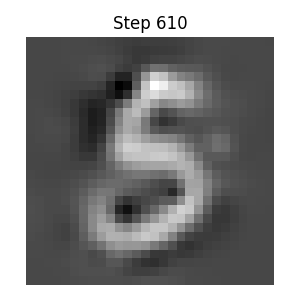

File: render_00620.png


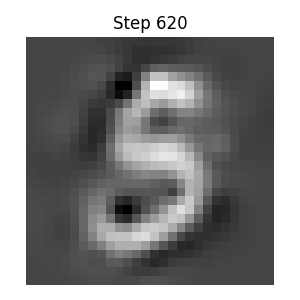

File: render_00630.png


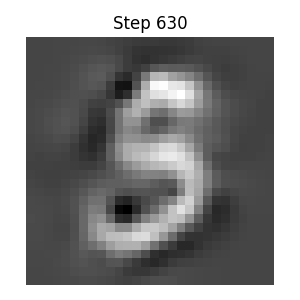

File: render_00640.png


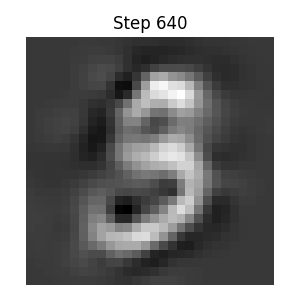

File: render_00650.png


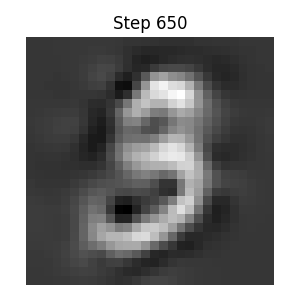

File: render_00660.png


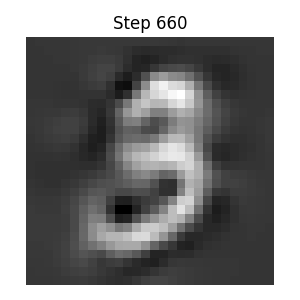

File: render_00670.png


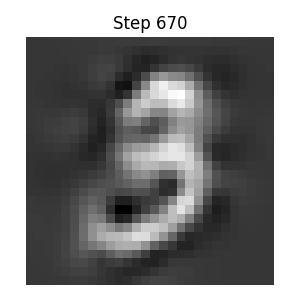

File: render_00680.png


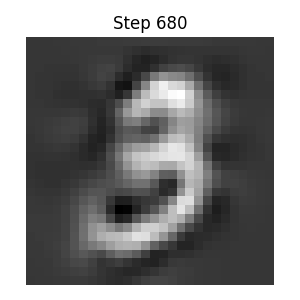

File: render_00690.png


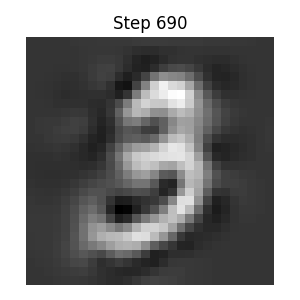

File: render_00700.png


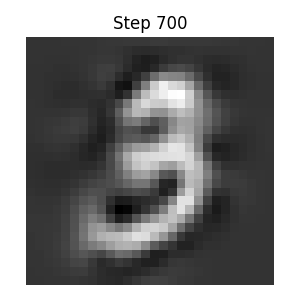

File: render_00710.png


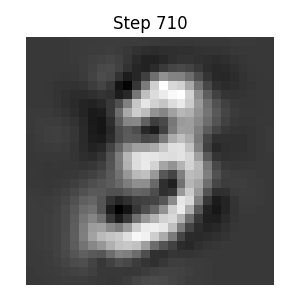

File: render_00720.png


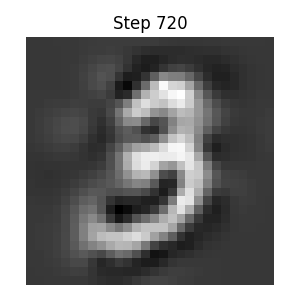

File: render_00730.png


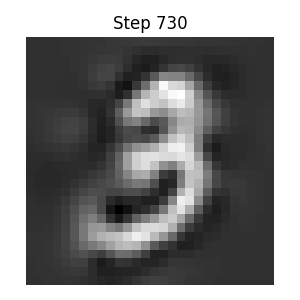

File: render_00740.png


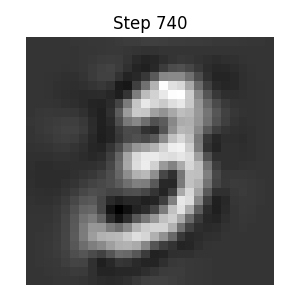

File: render_00750.png


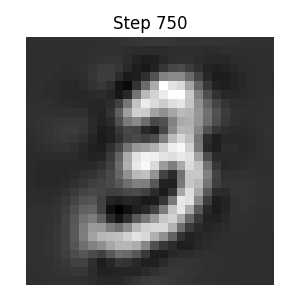

File: render_00760.png


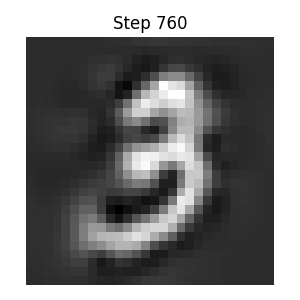

File: render_00770.png


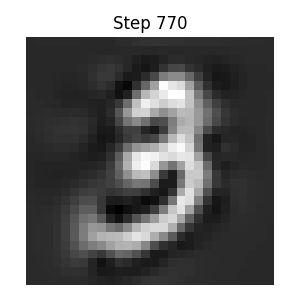

File: render_00780.png


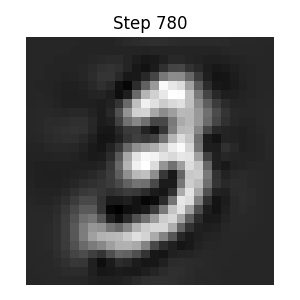

File: render_00790.png


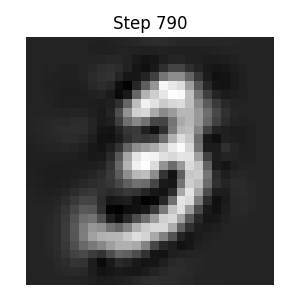

File: render_00799.png


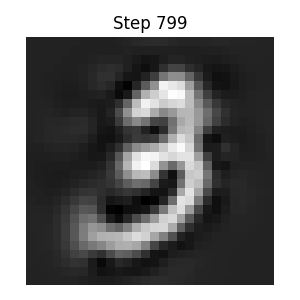

File: render_00800.png


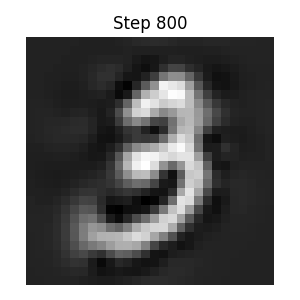

File: render_00810.png


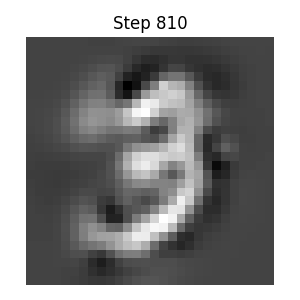

File: render_00820.png


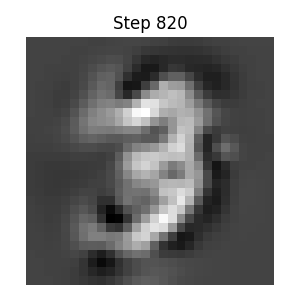

File: render_00830.png


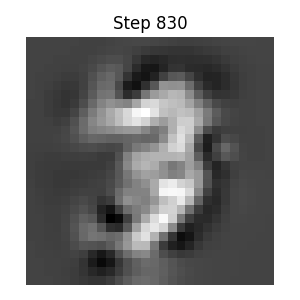

File: render_00840.png


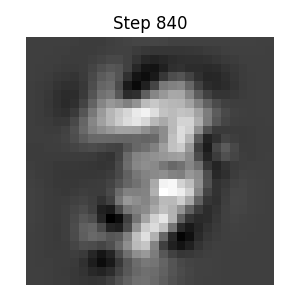

File: render_00850.png


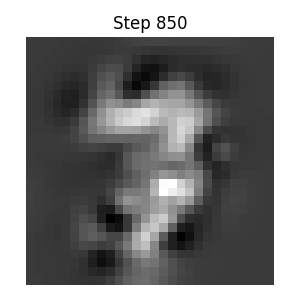

File: render_00860.png


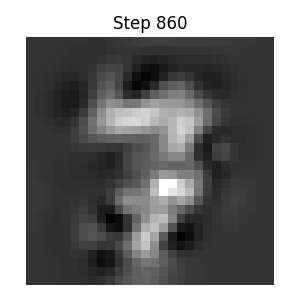

File: render_00870.png


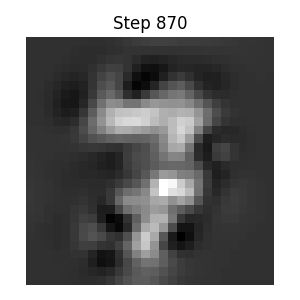

File: render_00880.png


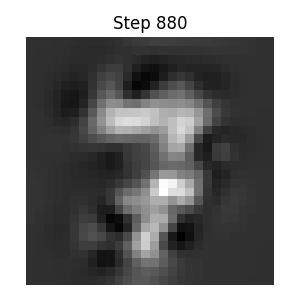

File: render_00890.png


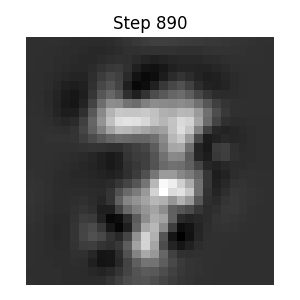

File: render_00900.png


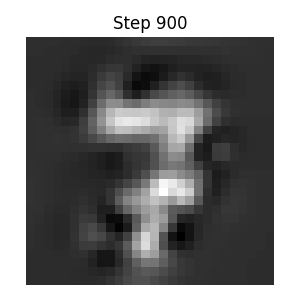

File: render_00910.png


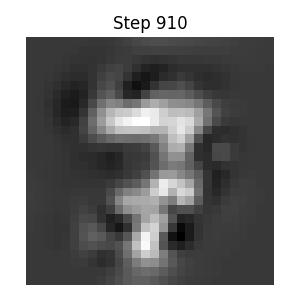

File: render_00920.png


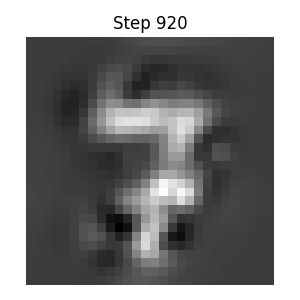

File: render_00930.png


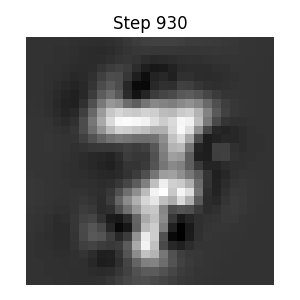

File: render_00940.png


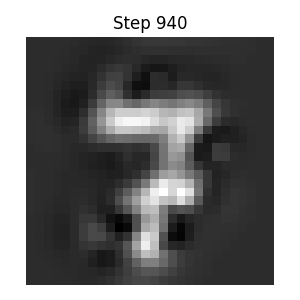

File: render_00950.png


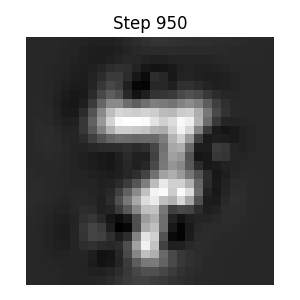

File: render_00960.png


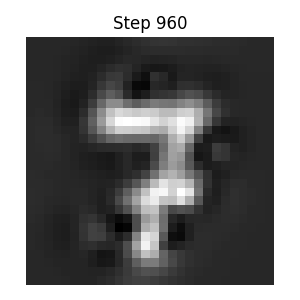

File: render_00970.png


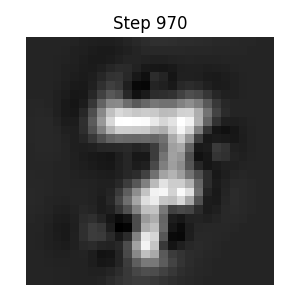

File: render_00980.png


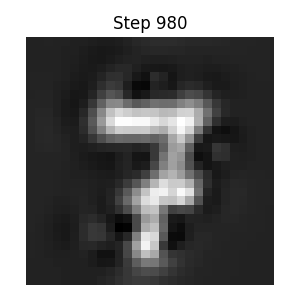

File: render_00990.png


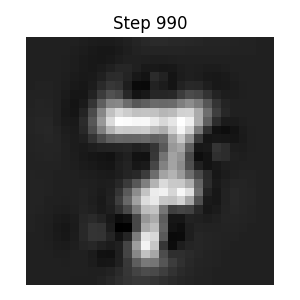

File: render_00999.png


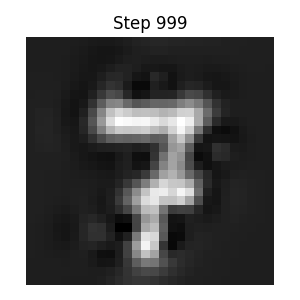

File: render_01000.png


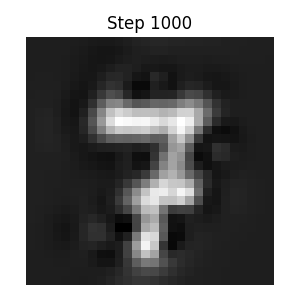

File: render_01010.png


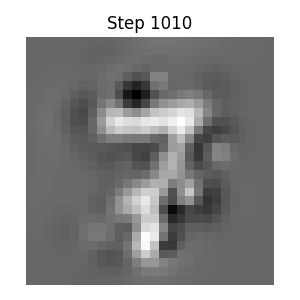

File: render_01020.png


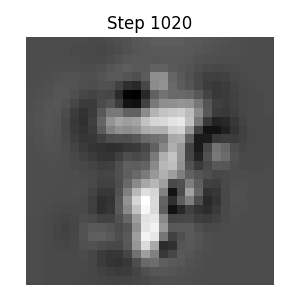

File: render_01030.png


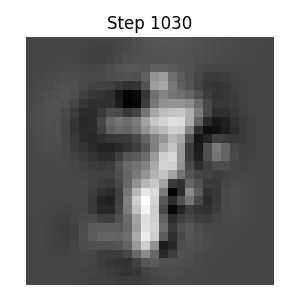

File: render_01040.png


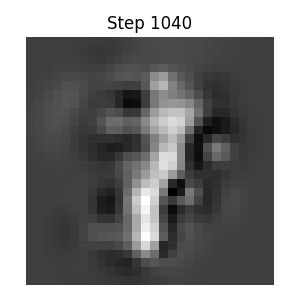

File: render_01050.png


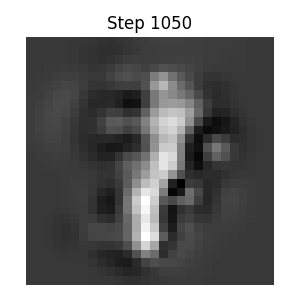

File: render_01060.png


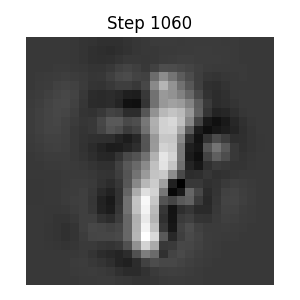

File: render_01070.png


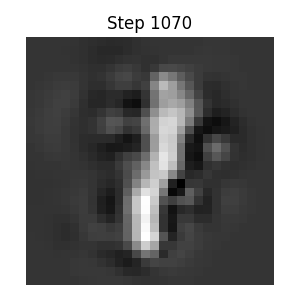

File: render_01080.png


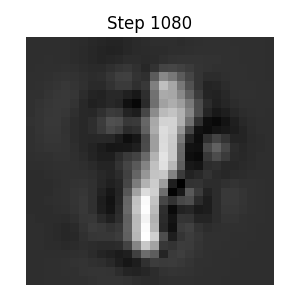

File: render_01090.png


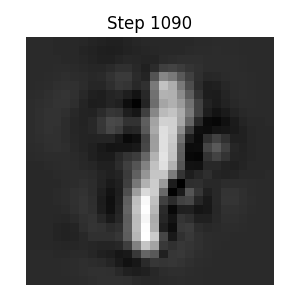

File: render_01100.png


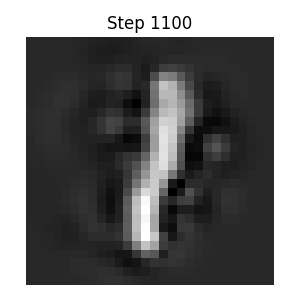

File: render_01110.png


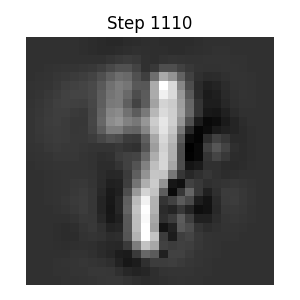

File: render_01120.png


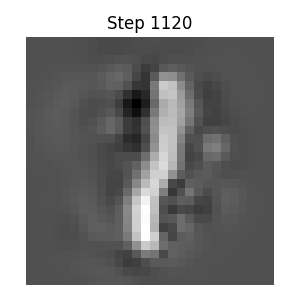

File: render_01130.png


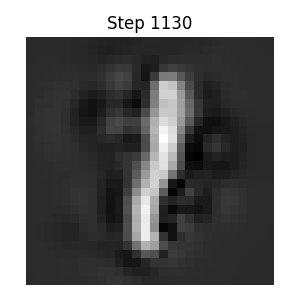

File: render_01140.png


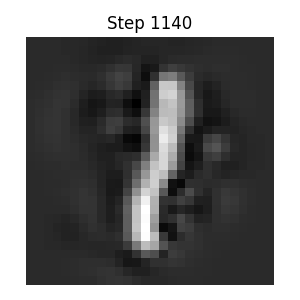

File: render_01150.png


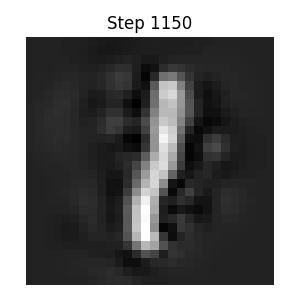

File: render_01160.png


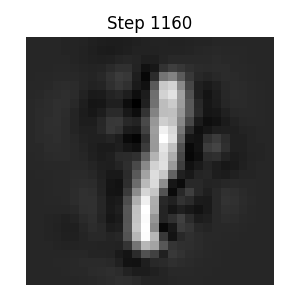

File: render_01170.png


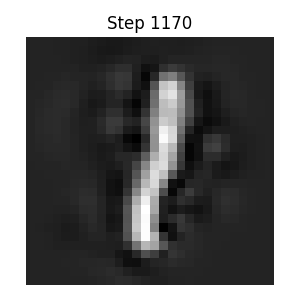

File: render_01180.png


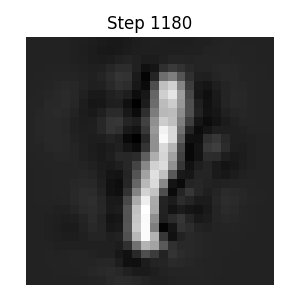

File: render_01190.png


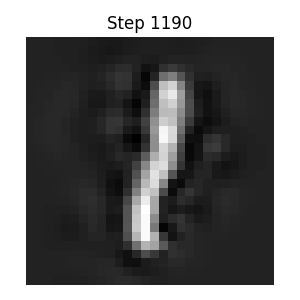

File: render_01199.png


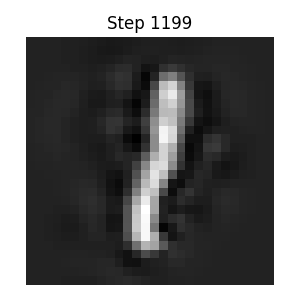

File: render_01200.png


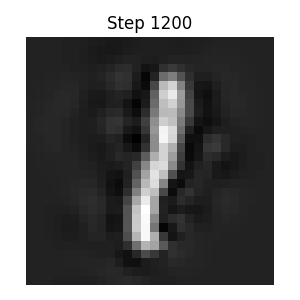

File: render_01210.png


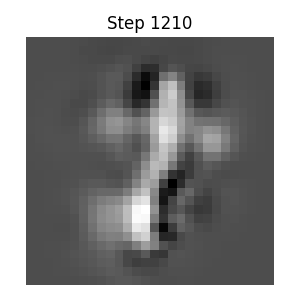

File: render_01220.png


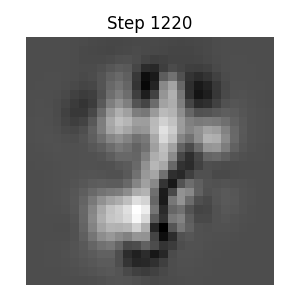

File: render_01230.png


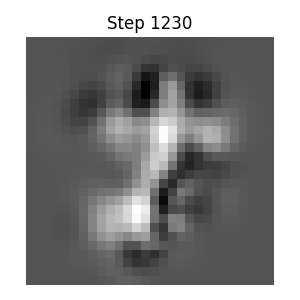

File: render_01240.png


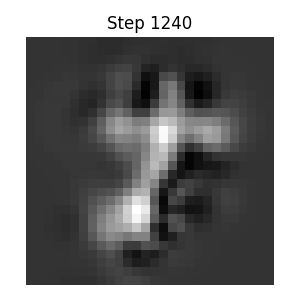

File: render_01250.png


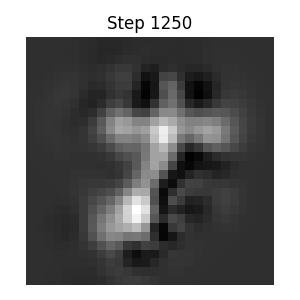

File: render_01260.png


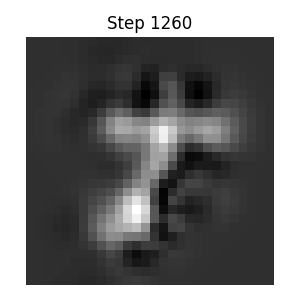

File: render_01270.png


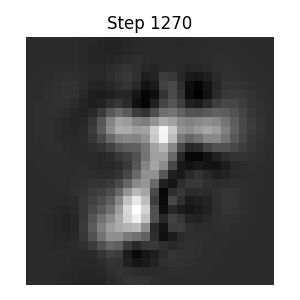

File: render_01280.png


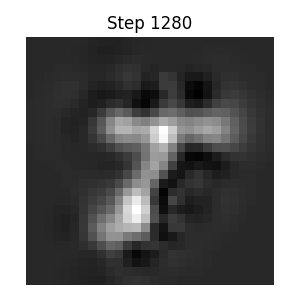

File: render_01290.png


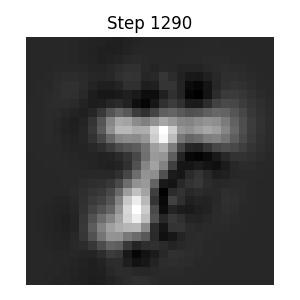

File: render_01300.png


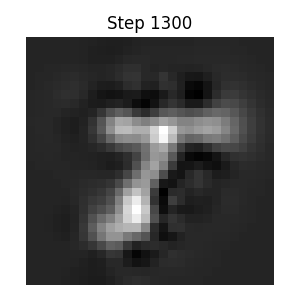

File: render_01310.png


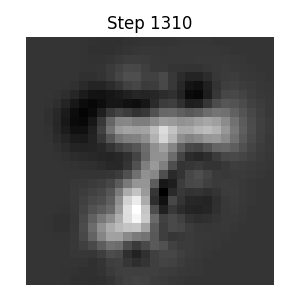

File: render_01320.png


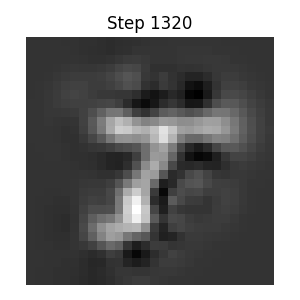

File: render_01330.png


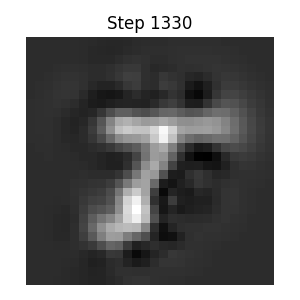

File: render_01340.png


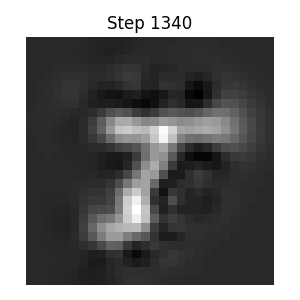

File: render_01350.png


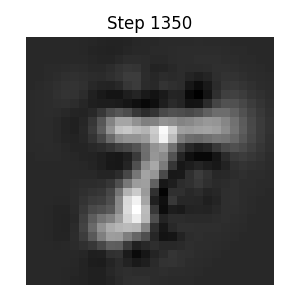

File: render_01360.png


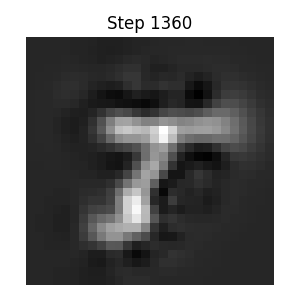

File: render_01370.png


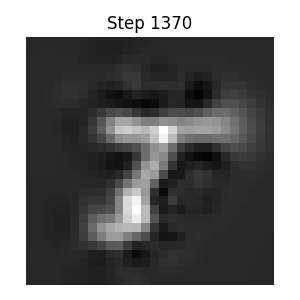

File: render_01380.png


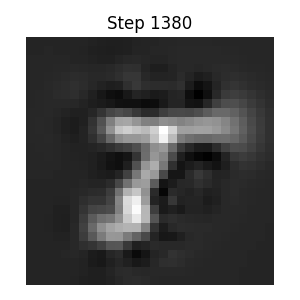

File: render_01390.png


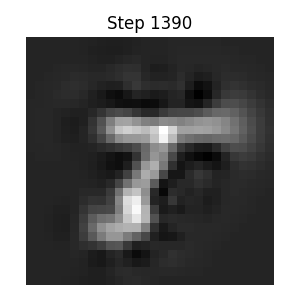

File: render_01399.png


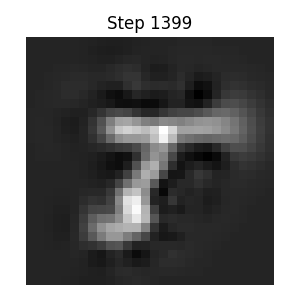

File: render_01400.png


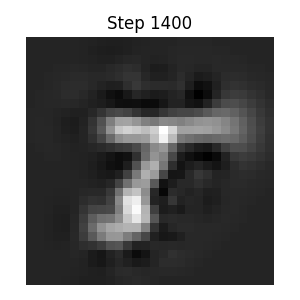

File: render_01410.png


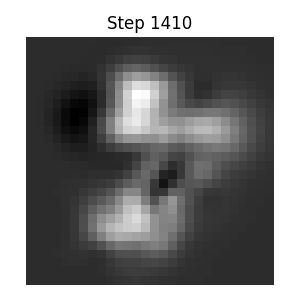

File: render_01420.png


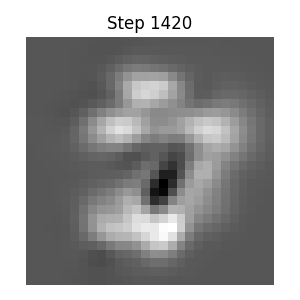

File: render_01430.png


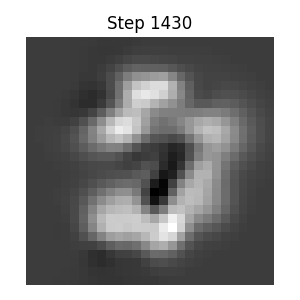

File: render_01440.png


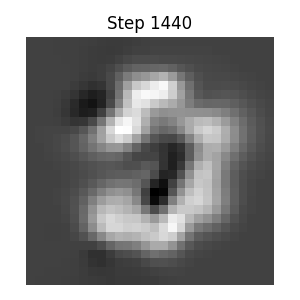

File: render_01450.png


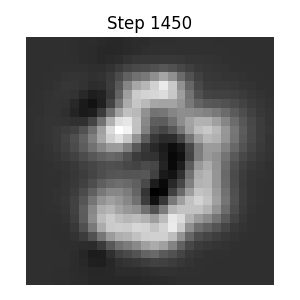

File: render_01460.png


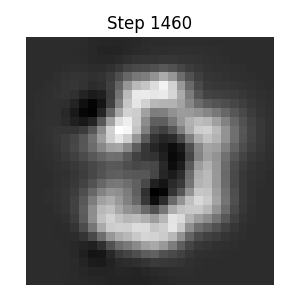

File: render_01470.png


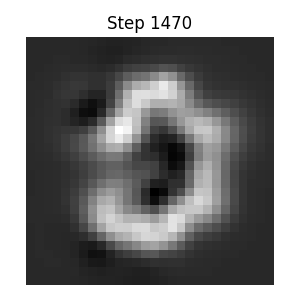

File: render_01480.png


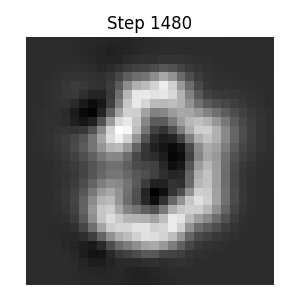

File: render_01490.png


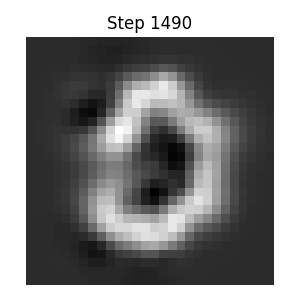

File: render_01500.png


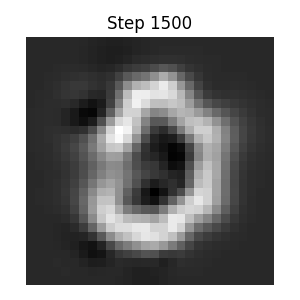

File: render_01510.png


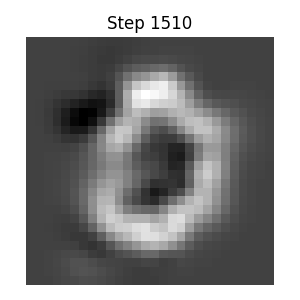

File: render_01520.png


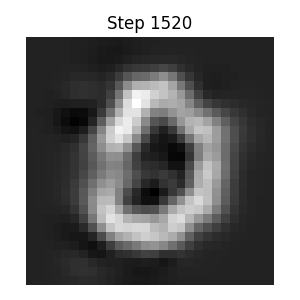

File: render_01530.png


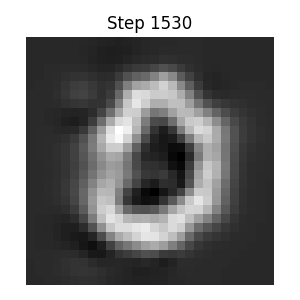

File: render_01540.png


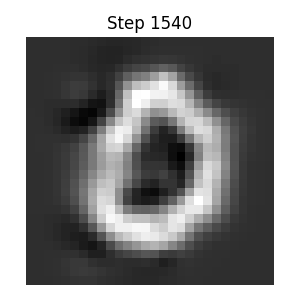

File: render_01550.png


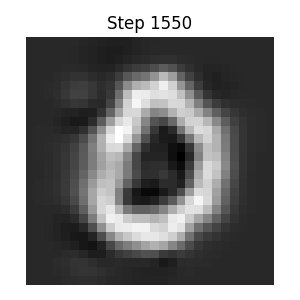

File: render_01560.png


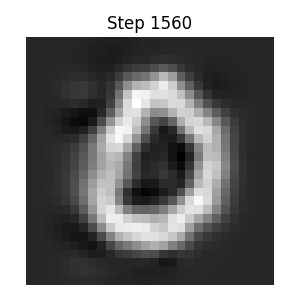

File: render_01570.png


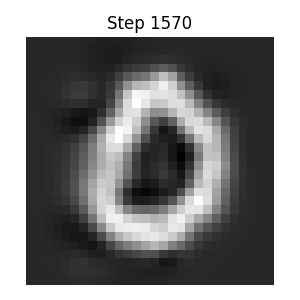

File: render_01580.png


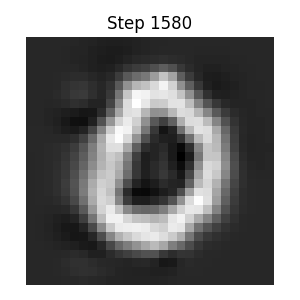

File: render_01590.png


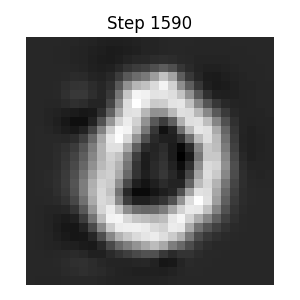

File: render_01599.png


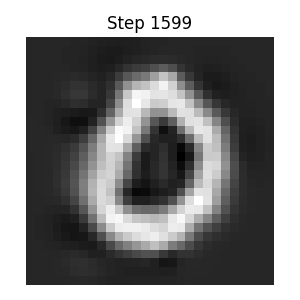

File: render_01600.png


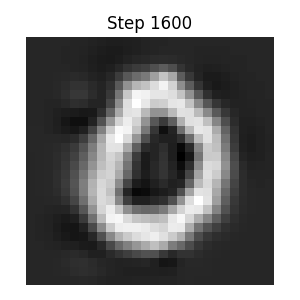

File: render_01610.png


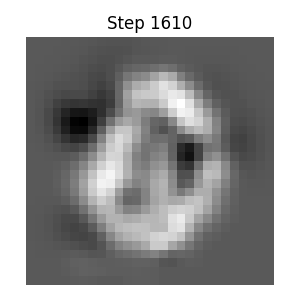

File: render_01620.png


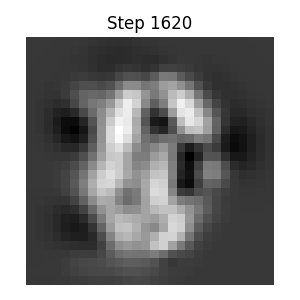

File: render_01630.png


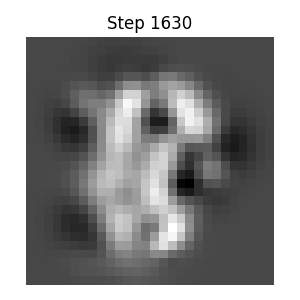

File: render_01640.png


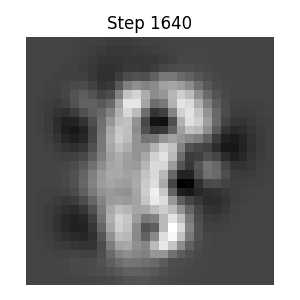

File: render_01650.png


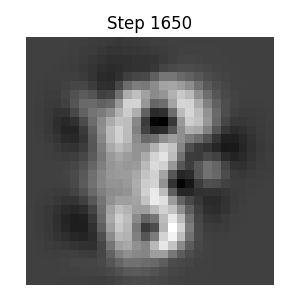

File: render_01660.png


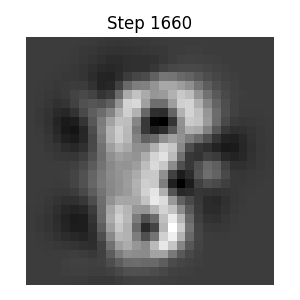

File: render_01670.png


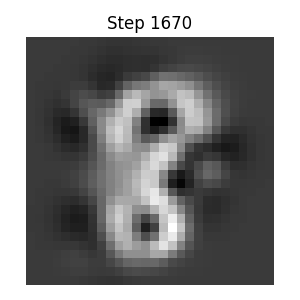

File: render_01680.png


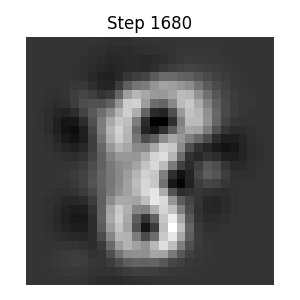

File: render_01690.png


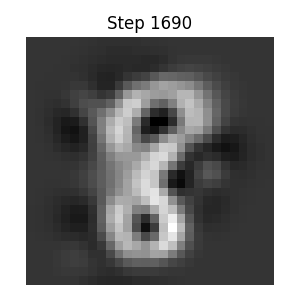

File: render_01700.png


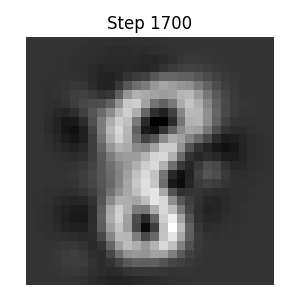

File: render_01710.png


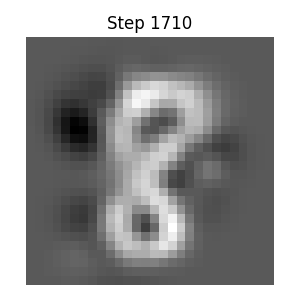

File: render_01720.png


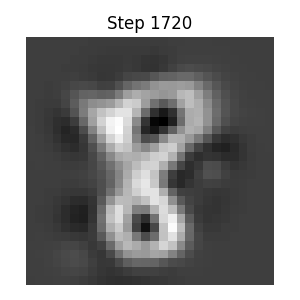

File: render_01730.png


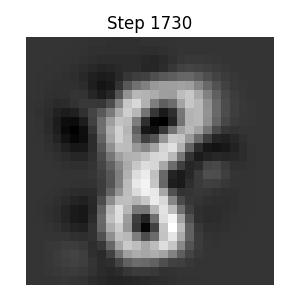

File: render_01740.png


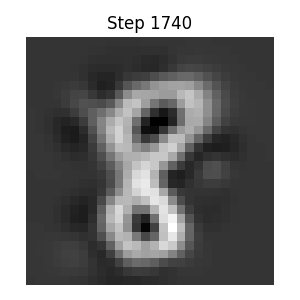

File: render_01750.png


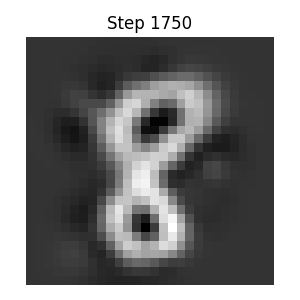

File: render_01760.png


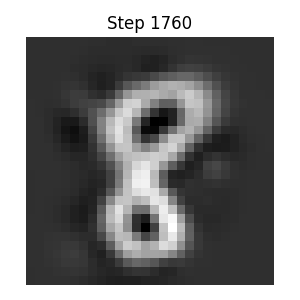

File: render_01770.png


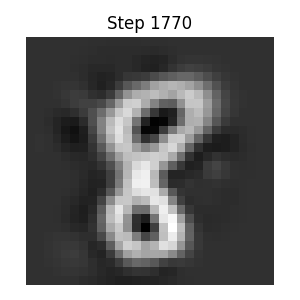

File: render_01780.png


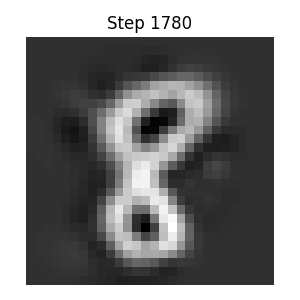

File: render_01790.png


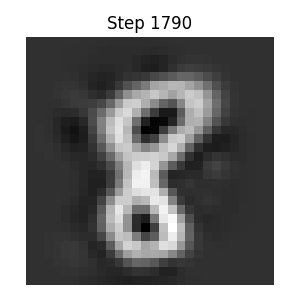

File: render_01799.png


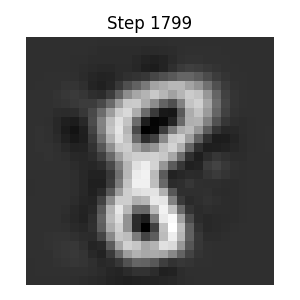

File: render_01800.png


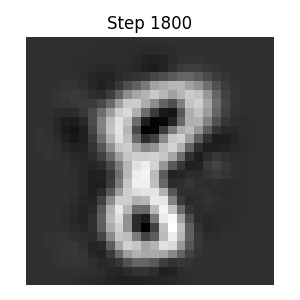

File: render_01810.png


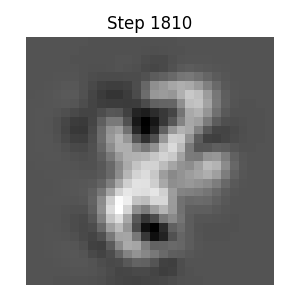

File: render_01820.png


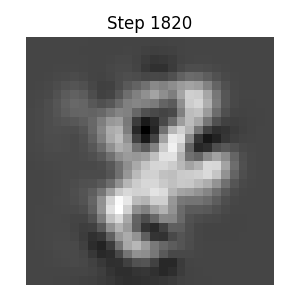

File: render_01830.png


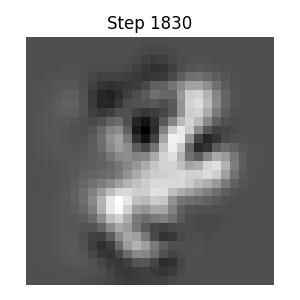

File: render_01840.png


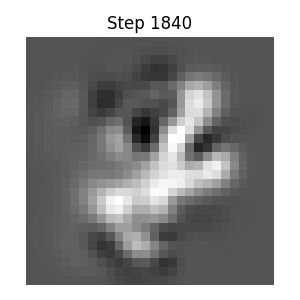

File: render_01850.png


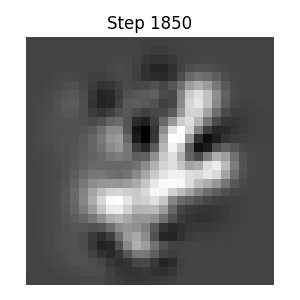

File: render_01860.png


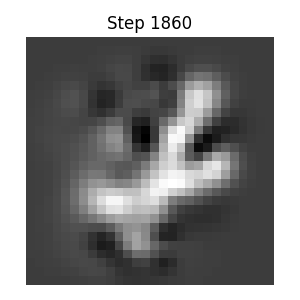

File: render_01870.png


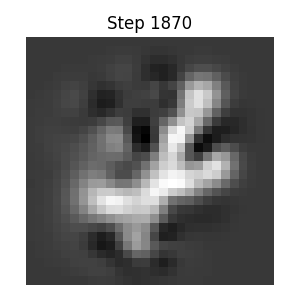

File: render_01880.png


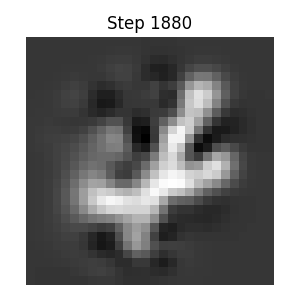

File: render_01890.png


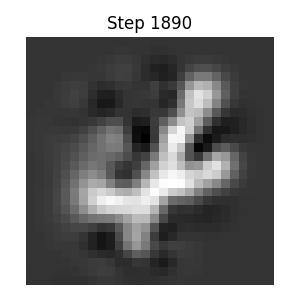

File: render_01900.png


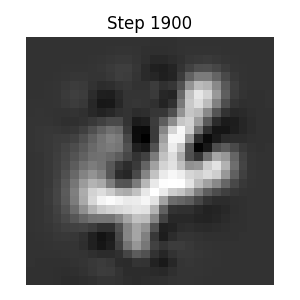

File: render_01910.png


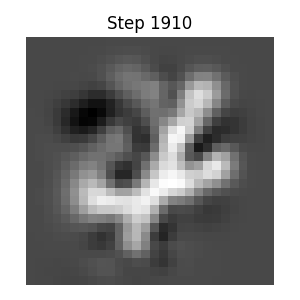

File: render_01920.png


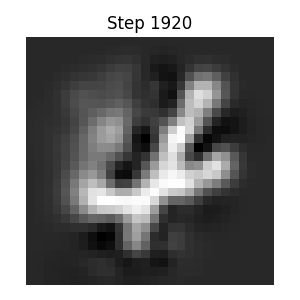

File: render_01930.png


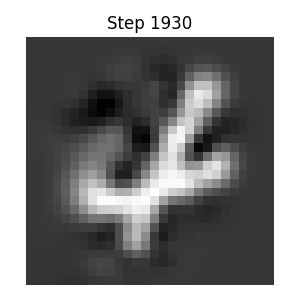

File: render_01940.png


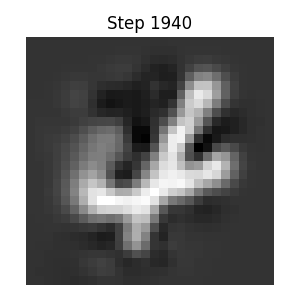

File: render_01950.png


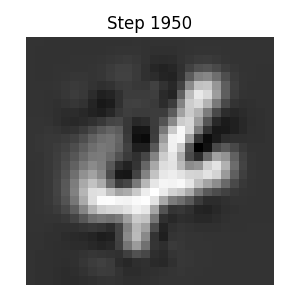

File: render_01960.png


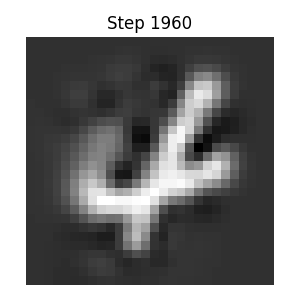

File: render_01970.png


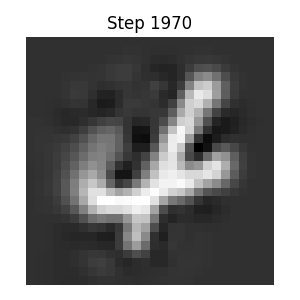

File: render_01980.png


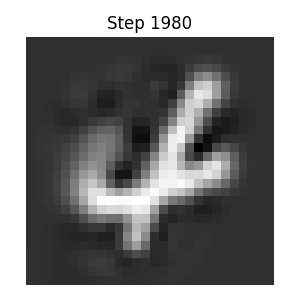

File: render_01990.png


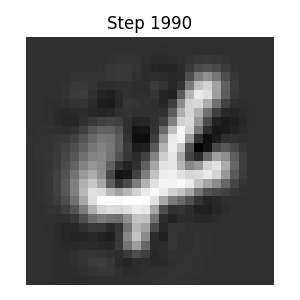

File: render_01999.png


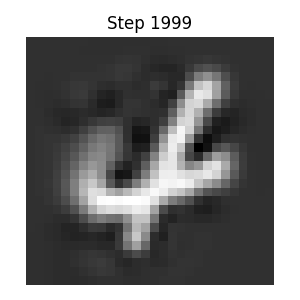


Display complete.


In [6]:

import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

PATH_TO_IMAGE_DIR = r'/kaggle/working/mnist_renders'


def display_all_renders():
    if not os.path.isdir(PATH_TO_IMAGE_DIR):
        print(f"Error: Directory not found at {PATH_TO_IMAGE_DIR}. Please ensure the training cell ran successfully and created this folder.")
        return

    #  Read all .png files 
    all_files = os.listdir(PATH_TO_IMAGE_DIR)
    
    # 2. Filter for PNG files and construct the full path
    # Sorting by name ensures they display in the correct numerical order (e.g., render_00000.png, render_00050.png, etc.)
    file_list = sorted([
        os.path.join(PATH_TO_IMAGE_DIR, f) 
        for f in all_files 
        if f.endswith('.png')
    ])
    
    total_frames = len(file_list)

    if total_frames == 0:
        print(f"No PNG renders found in the directory: {PATH_TO_IMAGE_DIR}")
        return

    print("="*50)
    print(f"DISPLAYING ALL {total_frames} RENDER FRAMES")
    print("="*50)
    
    # 3. Loop and display each image
    for file_path in file_list:
        # We display the file path and then the image for context
        print(f"File: {os.path.basename(file_path)}")
        display(Image(filename=file_path, width=150))
        
    print("\nDisplay complete.")

# Execute the visualization
display_all_renders()